In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from Bio import Phylo


In [3]:
# read C:\Users\pablo\OneDrive\Desktop\tree_clustering\data\traits_pred_log.csv
data = pd.read_csv('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\data\\traits_pred_log.csv')
trait_cols = data.columns[1:]
# read taxonomic_information.csv
tax = pd.read_csv('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\data\\taxonomic_information.csv')
# C:\Users\pablo\OneDrive\Desktop\tree_clustering\output\imputed_data\gaussian_mixture\clusters_200.csv
# clusters = pd.read_csv('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\output\\complete_data\\gaussian_mixture_full\\clusters_1000.csv',
#                        index_col=0)
clusters = pd.read_csv('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\server\\gmm_error1.0_rnd\\full_data\\final_clusters.csv',
                       index_col=0)

# read tree newick file
tree_path = ('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\data\\phy_tree_BGCI_full.newick')
tree = Phylo.read(tree_path, 'newick')

# read C:\Users\pablo\OneDrive\Desktop\tree_clustering\data\phylogenetic_distance_matrix_BGCI_full.arrow
phylo_dist = pd.read_feather('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\data\\phylogenetic_distance_matrix_BGCI_full.arrow')

# C:\Users\pablo\OneDrive\Desktop\tree_clustering\output\complete_data\gaussian_mixture_full\cluster_means_875.csv
cluster_means = pd.read_csv('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\output\\complete_data\\gaussian_mixture_full\\cluster_means_1000.csv',
                            index_col=0)

In [4]:
# make index match column names for phylo_dist
phylo_dist.index = phylo_dist.columns

In [26]:
accepted_spcies = data['accepted_bin'].values
# filter tax dataframe to only include accepted species
tax = tax[tax['accepted_bin'].isin(accepted_spcies)]

## Phylo distance

In [5]:
def dist_tax(df_tax, tax_name):

    unique_tax = df_tax[tax_name].unique()
    tax_n_species_list = []
    tax_mean_phylo_dist_list = []

    for g in unique_tax:
        # get species in genus
        species = df_tax[df_tax[tax_name] == g]['accepted_bin'].tolist()
        n_species_g = len(species)
        if n_species_g == 0 or n_species_g == 1:
            continue
        # replace space with _
        species_ = [s.replace(' ', '_') for s in species]
        # get phylogenetic distance between species
        phylo_dist_g = phylo_dist.loc[species_, species_]
        #get the mean phylogenetic distance (for non-diagonal elements)    
        mean_k = np.sum(phylo_dist_g.values) / (n_species_g*(n_species_g-1))

        tax_n_species_list.append(n_species_g)
        tax_mean_phylo_dist_list.append(mean_k)
    
    return tax_n_species_list, tax_mean_phylo_dist_list
    
# dataframe
# genus_dist = pd.DataFrame.from_dict(genus_dist, orient='index', columns=['mean_phylo_dist'])
    

In [33]:
# genus
print('Calculating distances for genus')
n_species_genus, mean_phylo_dist_genus = dist_tax(tax, 'genus')
# family
print('Calculating distances for family')
n_species_family, mean_phylo_dist_family = dist_tax(tax, 'family')
# order
print('Calculating distances for order')
n_species_order, mean_phylo_dist_order = dist_tax(tax, 'order')
# group
# print('Calculating distances for group')
# n_species_group, mean_phylo_dist_group = dist_tax(tax, 'group')

Calculating distances for genus
Calculating distances for family
Calculating distances for order


In [17]:
k_list = clusters['cluster'].unique()
n_species_list = []
mean_distance_list = []
mean_trait_distance_list = []


for k in k_list:
    cluster_k = clusters[clusters['cluster'] == k]

    # get species from cluster_k (accepted_bin)
    species = cluster_k.index
    # change spaces to underscores
    species_ = species.str.replace(' ', '_')
    n_species_k = len(species)

    # iterate over species and get the phylogenetic distance
    phylo_dist_k = phylo_dist.loc[species_, species_]

    # trait_dist_list = []
    # # get trait distances
    # for x in range(len(species)):
    #     for y in range(x+1, len(species)):
    #         # get trait distance
    #         trait_dist = np.sqrt(np.sum((cluster_k.loc[species[x], trait_cols] - cluster_k.loc[species[y], trait_cols])**2))
    # mean_trait_distance_list.append(np.mean(trait_dist_list))
                

    # get the mean phylogenetic distance (for non-diagonal elements)    
    mean_k = np.sum(phylo_dist_k.values) / (n_species_k*(n_species_k-1))

    print(f'Cluster {k}, mean distance {mean_k}, n_species {len(species)}')

    n_species_list.append(len(species))
    mean_distance_list.append(mean_k)

Cluster 817, mean distance 59.28125504431599, n_species 519
Cluster 425, mean distance 34.81238211308348, n_species 340
Cluster 3, mean distance 18.54391728834356, n_species 326
Cluster 6, mean distance 14.757977307152496, n_species 286
Cluster 33, mean distance 86.37832, n_species 275
Cluster 54, mean distance 34.59710758615116, n_species 223
Cluster 181, mean distance 17.18909413613496, n_species 218
Cluster 59, mean distance 18.016351539121885, n_species 212
Cluster 689, mean distance 23.933779544998863, n_species 210
Cluster 532, mean distance 17.656272714847265, n_species 206
Cluster 839, mean distance 13.504480000000001, n_species 205
Cluster 152, mean distance 30.114440000000002, n_species 204
Cluster 858, mean distance 59.28125999999998, n_species 202
Cluster 579, mean distance 24.30427795084577, n_species 201
Cluster 89, mean distance 170.271490718593, n_species 200
Cluster 60, mean distance 32.46093967522945, n_species 198
Cluster 221, mean distance 51.991623856611454, n_spec

In [40]:
def fit_gmm_and_assign_clusters(data, tax, trait_cols, n_components, level_name):
    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    gmm.fit(data[trait_cols])
    
    # Get cluster names
    cluster_names = gmm.predict(data[trait_cols])
    
    # Assign cluster names to data
    cluster_col_name = f'cluster_{level_name}'
    data[cluster_col_name] = cluster_names
    
    # Merge with tax DataFrame
    tax[cluster_col_name] = tax['accepted_bin'].map(data.set_index('accepted_bin')[cluster_col_name])

# Number of clusters for each level
n_genus = len(n_species_genus)
n_family = len(n_species_family)
n_order = len(n_species_order)

# Fit GMM and assign clusters for genus
fit_gmm_and_assign_clusters(data, tax, trait_cols, n_genus, 'genus')

# Fit GMM and assign clusters for family
fit_gmm_and_assign_clusters(data, tax, trait_cols, n_family, 'family')

# Fit GMM and assign clusters for order
fit_gmm_and_assign_clusters(data, tax, trait_cols, n_order, 'order')

In [43]:
# genus cluster
print('Calculating distances for genus')
n_species_genus_cluster, mean_phylo_dist_genus_cluster = dist_tax(tax, 'cluster_genus')
# family cluster
print('Calculating distances for family')
n_species_family_cluster, mean_phylo_dist_family_cluster = dist_tax(tax, 'cluster_family')
# order cluster
print('Calculating distances for order')
n_species_order_cluster, mean_phylo_dist_order_cluster = dist_tax(tax, 'cluster_order')

Calculating distances for genus
Calculating distances for family
Calculating distances for order


## Same Size Clusters to Phylo

Text(0.5, 1.0, 'Cluster Order')

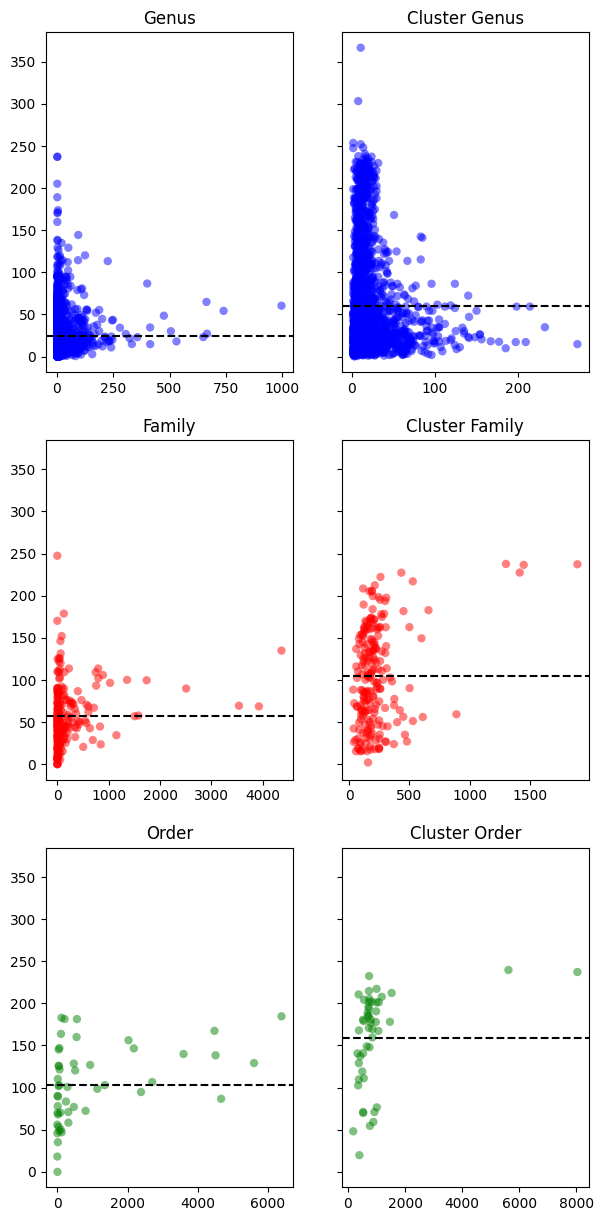

In [50]:
fig, axs = plt.subplots(3,2, figsize=(7, 15), sharey=True)

## GENUS ##
axs[0,0].scatter(n_species_genus, mean_phylo_dist_genus, label='Genus',
                 color='blue', alpha=0.5, edgecolors='none')

axs[0,1].scatter(n_species_genus_cluster, mean_phylo_dist_genus_cluster, label='Cluster Genus',
                 color='blue', alpha=0.5, edgecolors='none')
# line with average
mean_phylo_dist_genus_cluster_avg = np.mean(mean_phylo_dist_genus_cluster)
axs[0,1].axhline(mean_phylo_dist_genus_cluster_avg, color='black', linestyle='--')
mean_phylo_dist_genus_avg = np.mean(mean_phylo_dist_genus)
axs[0,0].axhline(mean_phylo_dist_genus_avg, color='black', linestyle='--')
# TITLE
axs[0,0].set_title('Genus')
axs[0,1].set_title('Cluster Genus')

## FAMILY ##
axs[1,0].scatter(np.log10(n_species_family), mean_phylo_dist_family, label='Family',
                 color='red', alpha=0.5, edgecolors='none')

axs[1,1].scatter(np.log10(n_species_family_cluster), mean_phylo_dist_family_cluster, label='Cluster Family',
                 color='red', alpha=0.5, edgecolors='none')
# line with average
mean_phylo_dist_family_cluster_avg = np.mean(mean_phylo_dist_family_cluster)
axs[1,1].axhline(mean_phylo_dist_family_cluster_avg, color='black', linestyle='--')
mean_phylo_dist_family_avg = np.mean(mean_phylo_dist_family)
axs[1,0].axhline(mean_phylo_dist_family_avg, color='black', linestyle='--')
# TITLE
axs[1,0].set_title('Family')
axs[1,1].set_title('Cluster Family')


## ORDER ##
axs[2,0].scatter(n_species_order, mean_phylo_dist_order, label='Order',
                 color='green', alpha=0.5, edgecolors='none')
axs[2,1].scatter(n_species_order_cluster, mean_phylo_dist_order_cluster, label='Cluster Order',
                 color='green', alpha=0.5, edgecolors='none')
# line with average
mean_phylo_dist_order_cluster_avg = np.mean(mean_phylo_dist_order_cluster)
axs[2,1].axhline(mean_phylo_dist_order_cluster_avg, color='black', linestyle='--')
mean_phylo_dist_order_avg = np.mean(mean_phylo_dist_order)
axs[2,0].axhline(mean_phylo_dist_order_avg, color='black', linestyle='--')
# TITLE
axs[2,0].set_title('Order')
axs[2,1].set_title('Cluster Order')





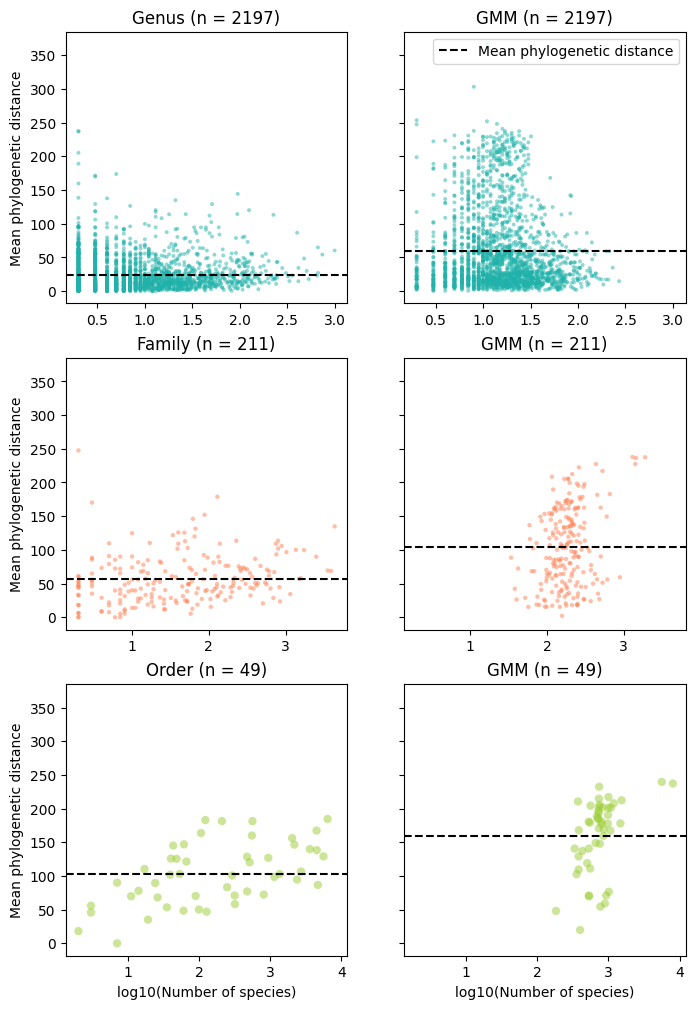

In [68]:
fig, axs = plt.subplots(3, 2, figsize=(8, 12), sharey=True)


# Configure sharing x-axis within each row
axs[0, 1].sharex(axs[0, 0])
axs[1, 1].sharex(axs[1, 0])
axs[2, 1].sharex(axs[2, 0])

## GENUS ##
axs[0, 0].scatter(np.log10(n_species_genus), mean_phylo_dist_genus,
                  color='lightseagreen', alpha=0.5, edgecolors='none', s = 8)

axs[0, 1].scatter(np.log10(n_species_genus_cluster), mean_phylo_dist_genus_cluster,
                  color='lightseagreen', alpha=0.5, edgecolors='none', s = 8)
# line with average
mean_phylo_dist_genus_avg = np.mean(mean_phylo_dist_genus)
mean_phylo_dist_genus_cluster_avg = np.mean(mean_phylo_dist_genus_cluster)
axs[0, 0].axhline(mean_phylo_dist_genus_avg, color='black', linestyle='--',
                   label=f'Mean phylogenetic distance')
axs[0, 1].axhline(mean_phylo_dist_genus_cluster_avg, color='black', linestyle='--',
                   label=f'Mean phylogenetic distance')
# TITLE
n_genus = len(n_species_genus)
axs[0, 0].set_title(f'Genus (n = {n_genus})')
axs[0, 1].set_title(f'GMM (n = {n_genus})')

## FAMILY ##
axs[1, 0].scatter(np.log10(n_species_family), mean_phylo_dist_family,
                  color='coral', alpha=0.5, edgecolors='none', s= 10)

axs[1, 1].scatter(np.log10(n_species_family_cluster), mean_phylo_dist_family_cluster,
                  color='coral', alpha=0.5, edgecolors='none', s = 10)
# line with average
mean_phylo_dist_family_avg = np.mean(mean_phylo_dist_family)
mean_phylo_dist_family_cluster_avg = np.mean(mean_phylo_dist_family_cluster)
axs[1, 0].axhline(mean_phylo_dist_family_avg, color='black', linestyle='--')
axs[1, 1].axhline(mean_phylo_dist_family_cluster_avg, color='black', linestyle='--')
# TITLE
n_family = len(n_species_family)
axs[1, 0].set_title(f'Family (n = {n_family})')
axs[1, 1].set_title(f'GMM (n = {n_family})')

## ORDER ##
axs[2, 0].scatter(np.log10(n_species_order), mean_phylo_dist_order, 
                  color='yellowgreen', alpha=0.5, edgecolors='none')
axs[2, 1].scatter(np.log10(n_species_order_cluster), mean_phylo_dist_order_cluster, 
                  color='yellowgreen', alpha=0.5, edgecolors='none')
# line with average
mean_phylo_dist_order_avg = np.mean(mean_phylo_dist_order)
mean_phylo_dist_order_cluster_avg = np.mean(mean_phylo_dist_order_cluster)
axs[2, 0].axhline(mean_phylo_dist_order_avg, color='black', linestyle='--')
axs[2, 1].axhline(mean_phylo_dist_order_cluster_avg, color='black', linestyle='--')
# TITLE
n_order = len(n_species_order)
axs[2, 0].set_title(f'Order (n = {n_order})')
axs[2, 1].set_title(f'GMM (n = {n_order})')


# legend
axs[0, 1].legend(loc='upper right')

# Set x-axis labels
axs[2, 0].set_xlabel('log10(Number of species)')
axs[2, 1].set_xlabel('log10(Number of species)')
# Set y-axis labels
axs[0, 0].set_ylabel('Mean phylogenetic distance')
axs[1, 0].set_ylabel('Mean phylogenetic distance')
axs[2, 0].set_ylabel('Mean phylogenetic distance')

# Display the plot
plt.show()


### Random assignationw

## PCAs

In [73]:
# define PCA and fit to data
pca = PCA(n_components=2)
pca.fit(data[trait_cols])

# merge data and tax dataframes
full_df = pd.merge(data, tax, on='accepted_bin')

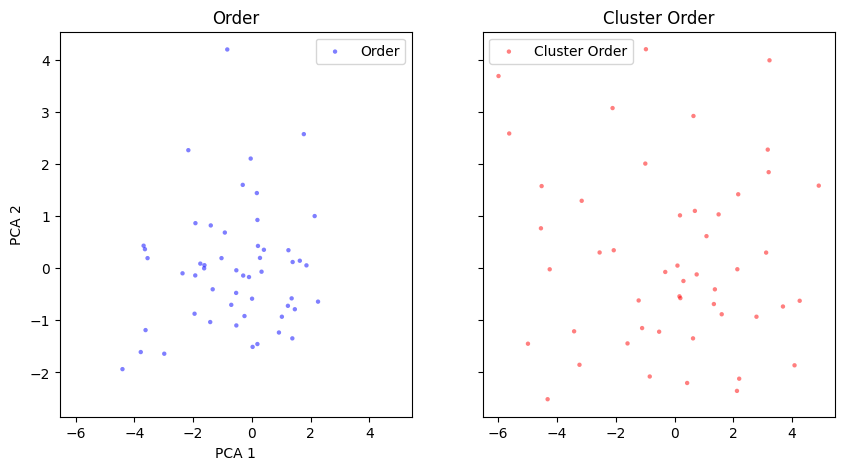

In [113]:
def plot_taxonomic_level_pca(level, df, pca, trait_cols):
    # Get means of trait columns for the specified level and its cluster
    mean_level = df.groupby(level).mean([trait_cols])
    mean_cluster_level = df.groupby(f'cluster_{level}_x').mean([trait_cols])

    # Transform both to PCA
    level_pca = pca.transform(mean_level[trait_cols])
    cluster_level_pca = pca.transform(mean_cluster_level[trait_cols])

    # # Plot
    # fig, ax = plt.subplots(figsize=(7, 7))
    # ax.scatter(level_pca[:, 0], level_pca[:, 1], color='blue', label=level.capitalize(), alpha=0.5, edgecolors='none')
    # ax.scatter(cluster_level_pca[:, 0], cluster_level_pca[:, 1], color='red', label=f'Cluster {level.capitalize()}', alpha=0.5, edgecolors='none')
    fig, axs = plt.subplots(1, 2, figsize=(10, 5),
                            sharex = True, sharey = True)  # Create two side-by-side subplots

# Plot for the specified taxonomic level
    axs[0].scatter(level_pca[:, 0], level_pca[:, 1], color='blue',
                    label=level.capitalize(), alpha=0.5, edgecolors='none',s = 10)
    axs[0].set_title(f'{level.capitalize()}')
    axs[0].legend()

    # Plot for the cluster associated with the taxonomic level
    axs[1].scatter(cluster_level_pca[:, 0], cluster_level_pca[:, 1], color='red', 
                   label=f'Cluster {level.capitalize()}', alpha=0.5, edgecolors='none', s = 10)
    axs[1].set_title(f'Cluster {level.capitalize()}')
    axs[1].legend()


    # Set labels and title
    axs[0].set_xlabel('PCA 1')
    axs[0].set_ylabel('PCA 2')
    # ax.set_title(f'PCA of {level.capitalize()} and Cluster {level.capitalize()}')
    # ax.legend()

    plt.show()

plot_taxonomic_level_pca('order', full_df, pca, trait_cols)

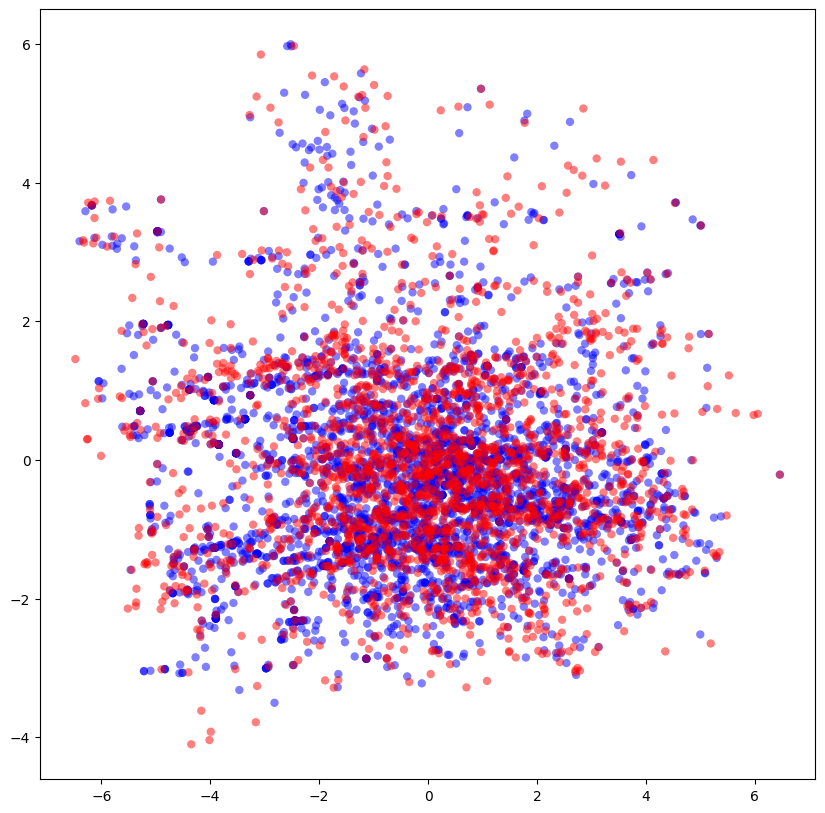

In [93]:
# get means of trait cols for genus and cluster_genus_x
mean_genus = full_df.groupby('genus').mean([trait_cols])
mean_cluster_genus = full_df.groupby('cluster_genus_x').mean([trait_cols])

# transform both to PCA
genus_pca = pca.transform(mean_genus[trait_cols])
cluster_genus_pca = pca.transform(mean_cluster_genus[trait_cols])

# plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(genus_pca[:, 0], genus_pca[:, 1], color='blue', label='Genus', alpha=0.5, edgecolors='none')
# plot cluster_genus
ax.scatter(cluster_genus_pca[:, 0], cluster_genus_pca[:, 1], color='red', label='Cluster Genus', alpha=0.5, edgecolors='none')

## Clusters vs Phylogenetic Levels

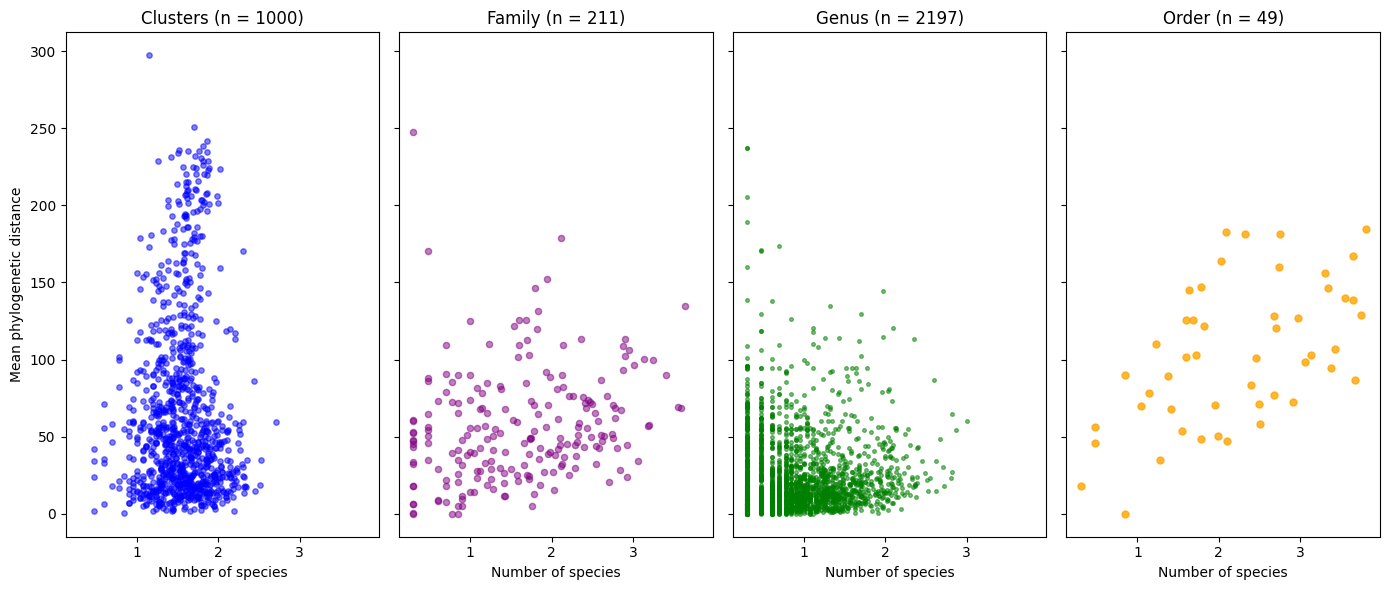

In [34]:
# Create a 1x4 grid of subplots with shared axes
fig, axs = plt.subplots(1, 4, figsize=(14, 6), sharex=True, sharey=True)

# Plot Clusters
axs[0].scatter(np.log10(n_species_list), mean_distance_list,
               s=15, c='blue', alpha=0.5)
axs[0].set_xlabel('Number of species')
axs[0].set_ylabel('Mean phylogenetic distance')
axs[0].set_title(f'Clusters (n = {len(n_species_list)})')

# Plot Family
axs[1].scatter(np.log10(n_species_family), mean_phylo_dist_family,
               s=20, c='purple', alpha=0.5)
axs[1].set_xlabel('Number of species')
axs[1].set_title(f'Family (n = {len(mean_phylo_dist_family)})')

# Plot Genus
axs[2].scatter(np.log10(n_species_genus), mean_phylo_dist_genus,
               s=7, c='green', alpha=0.5)
axs[2].set_xlabel('Number of species')
axs[2].set_title(f'Genus (n = {len(mean_phylo_dist_genus)})')

# Plot Order
axs[3].scatter(np.log10(n_species_order), mean_phylo_dist_order,
               s=25, c='orange', alpha=0.8)
axs[3].set_xlabel('Number of species')
axs[3].set_title(f'Order (n = {len(mean_phylo_dist_order)})')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


In [36]:
###### MIGHT BE USEFUL FOR SEEING WEIRD CASES ######
# count for order and sort ascending
tax_order = tax.groupby('genus').size().sort_values(ascending=True)
# filter those with more than 1 species
tax_order = tax_order[tax_order > 1]
for ord in tax_order.index[:20]:
    species = tax[tax['genus'] == ord]['accepted_bin'].tolist()
    species_ = [s.replace(' ', '_') for s in species]
    phylo_dist_ord = phylo_dist.loc[species_, species_]
    mean_k = np.sum(phylo_dist_ord.values) / (len(species)*(len(species)-1))
    if mean_k > 200:
        print(f'Order {ord}, mean distance {mean_k}, n_species {len(species)}')
        print(species)




# species = ['Dieffenbachia_tefensis', 'Rhodospatha_arborescens'] # order according to google: Arales, Alismatales
# phylo_dist_s = phylo_dist.loc[species, species]
# display(phylo_dist_s)

Order Lophostemon, mean distance 237.15816999999998, n_species 2
['Lophostemon suaveolens', 'Lophostemon confertus']


In [37]:
sp = ['Lophostemon_suaveolens', 'Lophostemon_confertus']
phylo_dist.loc[sp,sp]

,Lophostemon_suaveolens,Lophostemon_confertus
Lophostemon_suaveolens,0.00000,237.15817
Lophostemon_confertus,237.15817,0.00000


In [30]:
tax[tax['accepted_bin'] == 'Dieffenbachia tefensis']

,genus,family,order,group,accepted_bin,mono_fern


In [72]:
# take a random sample of phylo_dist
phylo_dist.head(1)

,Humiriastrum_subcrenatum,Humiriastrum_dentatum,Humiriastrum_glaziovii,Humiriastrum_cuspidatum,Humiriastrum_diguense,Humiriastrum_excelsum,Humiriastrum_colombianum,Humiriastrum_liesneri,Humiriastrum_mapiriense,Humiriastrum_melanocarpum,...,V62162,V62163,V62164,Gnetum_costatum,Gnetum_gnemon,Gnetum_nodiflorum,Gnetum_arboreum,V62169,V62170,Ginkgo_biloba
Humiriastrum_subcrenatum,0.0,22.396444,22.396452,22.396452,22.396452,22.396452,22.396452,22.396452,22.396452,22.396452,...,650.100492,650.100492,650.100494,650.100489,650.100489,650.100488,650.100483,650.100483,650.100483,650.100512


In [80]:
phylo_dist.loc[species,species]

,Tetracentron_sinense,Trochodendron_aralioides
Tetracentron_sinense,0.000000,18.160904
Trochodendron_aralioides,18.160904,0.000000


Text(0, 0.5, 'Mean phylogenetic distance')

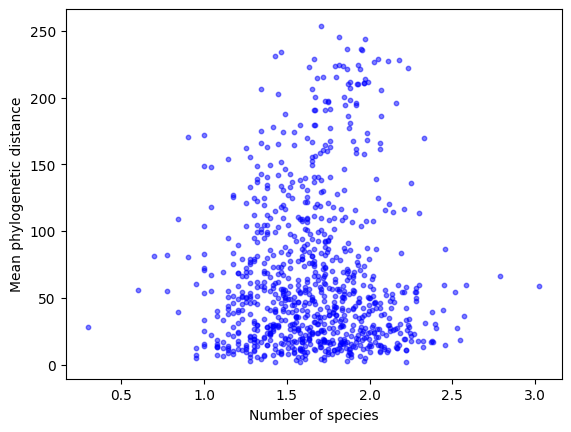

In [27]:
# plot mean distance vs n_species
plt.scatter(np.log10(n_species_list), mean_distance_list,
            s = 10, c = 'blue', alpha = 0.5)
plt.xlabel('Number of species')
plt.ylabel('Mean phylogenetic distance')


In [36]:
gmm = GaussianMixture(n_components= 875, covariance_type='full', 
                      means_init=cluster_means[trait_cols], random_state=0)
gmm.fit(data[trait_cols])

KeyboardInterrupt: 

## For one cluster


Text(0, 0.5, 'PC2')

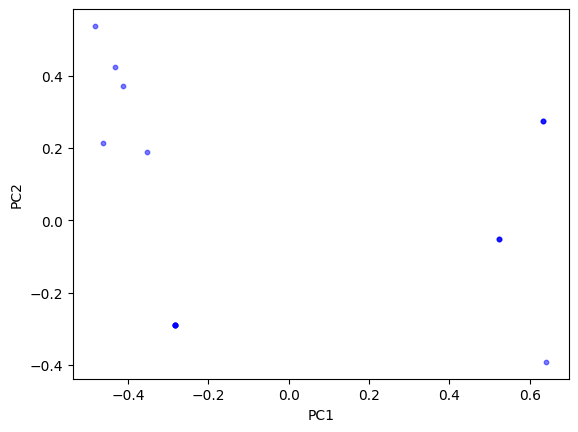

In [24]:
k = 611

# draw PCA plot for cluster k
cluster_k = clusters[clusters['cluster'] == k]


pca = PCA(n_components = 2)

# get species from cluster_k (accepted_bin)
species = cluster_k['accepted_bin']

# get the data for the species
data_k = data[data['accepted_bin'].isin(species)]

# get the trait data
trait_data = data_k[trait_cols]

# fit PCA
pca.fit(trait_data)

# transform data
data_k_pca = pca.transform(trait_data)

# # same for PCA complete
# pca_complete = PCA(n_components = 2)
# pca_complete.fit(data[trait_cols])
# data_pca_complete = pca_complete.transform(data_k[trait_cols])

# plot PCA
plt.scatter(data_k_pca[:, 0], data_k_pca[:, 1], s = 10, c = 'blue', alpha = 0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')

# # plot the species names
# for i, txt in enumerate(species):
#     plt.annotate(txt, (data_234_pca[i, 0], data_234_pca[i, 1]))

# plot the cluster centroid
# centroid = np.mean(data_234_pca, axis = 0)

# plt.scatter(centroid[0], centroid[1], s = 100, c = 'red', alpha = 0.5)



## Taxonomy


In [39]:
# join data and tax on accepted_bin columns
df = pd.merge(data, tax, on='accepted_bin')

In [15]:
# count how many species are for each group
df_group = df.groupby('group').count().reset_index()
df_group
### doesn't match with the number of species in the original data (Maynard et al. 2022)

,group,accepted_bin,Bark thickness,Crown diameter,Crown height,Leaf K per mass,Leaf N per mass,Leaf P per mass,Leaf Vcmax per dry mass,Leaf area,...,Specific leaf area,Stem conduit diameter,Stem diameter,Stomatal conductance,Tree height,Wood density,genus,family,order,mono_fern
0,Angiosperms,53524,53524,53524,53524,53524,53524,53524,53524,53524,...,53524,53524,53524,53524,53524,53524,53524,53524,53524,53524
1,Gymnosperms,571,571,571,571,571,571,571,571,571,...,571,571,571,571,571,571,571,571,571,571


In [4]:
# count unique for each tax column
# tax = tax.drop(columns=['accepted_bin'])
tax_count = tax.nunique()
print(tax_count)

genus            4013
family            253
order              57
group               2
accepted_bin    54095
mono_fern           2
dtype: int64


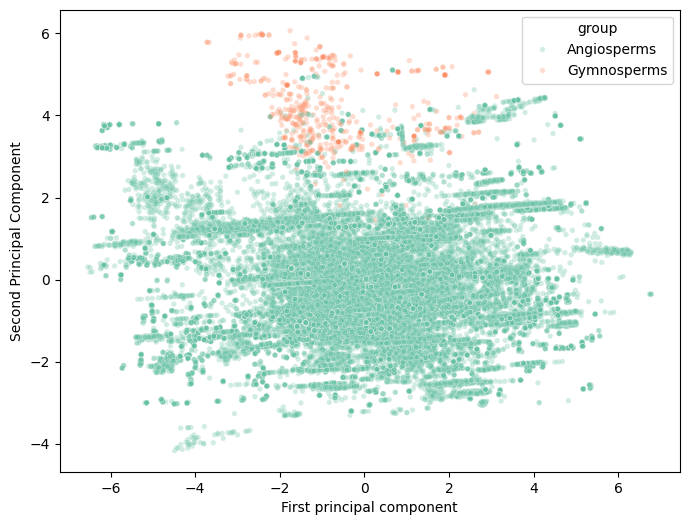

[0.51226002 0.19502879 0.08100309 0.04513813 0.03168642 0.02771892
 0.02274302 0.01600429]


In [8]:
# perform PCA over trait columns 
# scaler = StandardScaler()
# scaler.fit(df[trait_cols])
# scaled_data = scaler.transform(df[trait_cols])
pca = PCA(n_components=8)
pca.fit(df[trait_cols])
x_pca = pca.transform(df[trait_cols])
df['PC1'] = x_pca[:,0]
df['PC2'] = x_pca[:,1]

# plot PC1 vs PC2 using group as hue
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1',y='PC2',data=df,hue='group',
                s = 15, alpha = 0.3, palette = 'Set2')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.show()

# see how much variance is explained by each PC
print(pca.explained_variance_ratio_)


In [52]:
# join data of clusters and tax on accepted_bin columns
df_clusters = pd.merge(clusters, tax, on='accepted_bin')

In [53]:
tax_columns = ['genus', 'family', 'order', 'group']
# for each cluster, count the number of each taxonomic group using groupby
df_tax_count = df_clusters.groupby('cluster')[tax_columns].nunique()

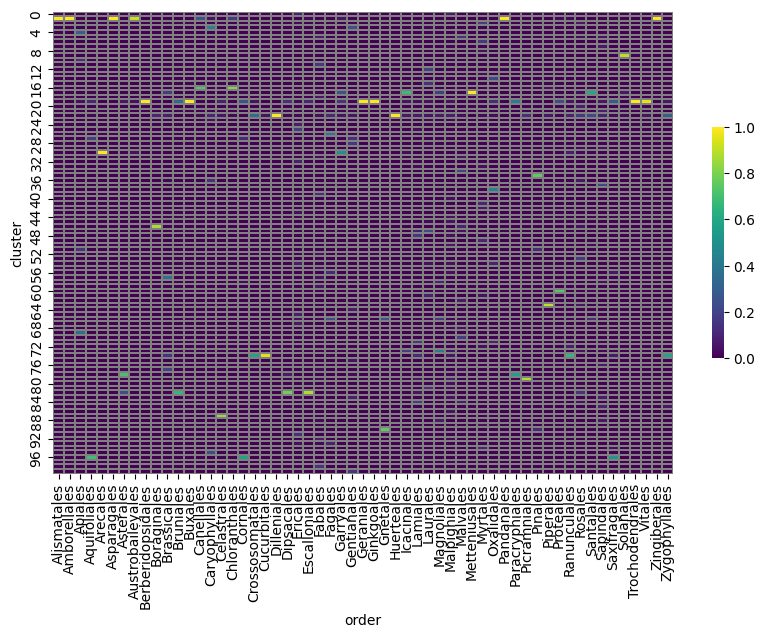

In [75]:
# pivot table for clusters and order
df_cluster_order = df_clusters.pivot_table(index='cluster', columns='order', values='accepted_bin', aggfunc='count', fill_value=0)

# Normalize by columns to get proportions
df_cluster_order = df_cluster_order.div(df_cluster_order.sum(axis=0), axis=1)

# plot heatmap of df_cluster_order
plt.figure(figsize=(10,6))
sns.heatmap(df_cluster_order, cmap='viridis', cbar=True, annot=False,
                 cbar_kws={'shrink': 0.5}, linewidths=0.004, linecolor='gray')
# show x ticks in the center of the cell
plt.xticks(np.arange(df_cluster_order.shape[1]) + 0.5, df_cluster_order.columns, rotation=90)
plt.show()


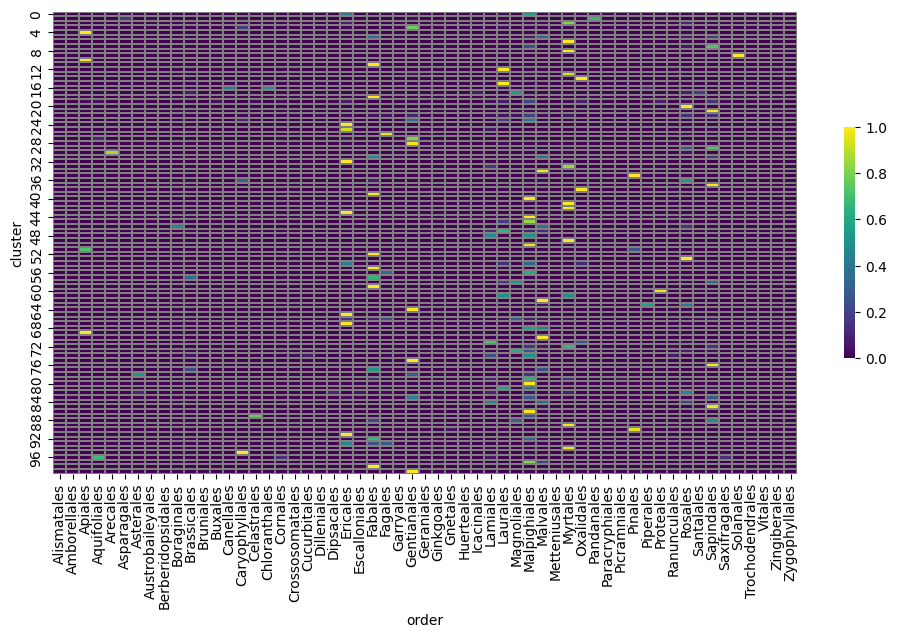

In [76]:
# pivot table for clusters and order
df_cluster_order = df_clusters.pivot_table(index='cluster', columns='order', values='accepted_bin', aggfunc='count', fill_value=0)

# Normalize by rows to get proportions
df_norm_rows = df_cluster_order.div(df_cluster_order.sum(axis=1), axis=0)

# plot heatmap of df_cluster_order
plt.figure(figsize=(12,6))
sns.heatmap(df_norm_rows, cmap='viridis', cbar=True, annot=False,
                 cbar_kws={'shrink': 0.5}, linewidths=0.004, linecolor='gray')
# show x ticks in the center of the cell
plt.xticks(np.arange(df_cluster_order.shape[1]) + 0.5, df_cluster_order.columns, rotation=90)
plt.show()

C:\Users\pablo\AppData\Local\Temp\ipykernel_9624\647162231.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_norm_rows.loc[ix, 'mean'] = row_mean


<Axes: xlabel='mean', ylabel='Count'>

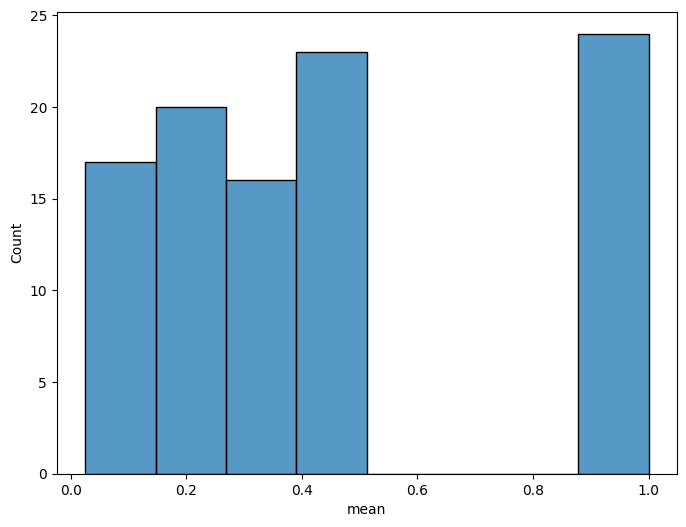

In [82]:
df_norm_rows['mean'] = 0
for ix, c in df_norm_rows.iterrows():
    row_mean = np.mean(c[c>0])
    df_norm_rows.loc[ix, 'mean'] = row_mean

# plot histogram of mean proportions
plt.figure(figsize=(8,6))
sns.histplot(df_norm_rows['mean'])

In [18]:
# # fit gaussian mixture
# from sklearn.mixture import GaussianMixture
# X = df[trait_cols]

# model = GaussianMixture(n_components=200, covariance_type='tied')
# model.fit(X)
# labels = model.predict(X)

# # add labels to df
# df['labels'] = labels

In [4]:
# Creating a pivot table with counts
pivot_table = df.pivot_table(index='cluster', columns='accepted_bin', aggfunc='size', fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='d')  # `fmt='d'` displays integer formatting
plt.title('Heatmap of Accepted Bins within Labels')
plt.xlabel('Accepted Bin')
plt.ylabel('Labels')
plt.show()

KeyboardInterrupt: 

In [6]:
# for each label show how many of each distinct group there are
grouped = df.groupby('cluster').accepted_bin.value_counts()

# Plotting
grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Accepted Bins within Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.legend(title='Accepted Bin')
plt.xticks(rotation=45)  # Rotates the labels on the x-axis for better readability
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits into the figure area.
plt.show()